# Artificial Intelligence Image Generator
## Generative AI (GenAI) - 002


<center>
<table align="center">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/christophergarthwood/jbooks/blob/main/STEM-002_GenAI_Images.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/notebooks?referrer=search&hl=en&project=usfs-ai-bootcamp">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Link to Colab Enterprise
    </a>
  </td>   
  <td style="text-align: center">
    <a href="https://github.com/christophergarthwood/jbooks/blob/main/STEM-002-GenAI_Images.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/instances?referrer=search&hl=en&project=usfs-ai-bootcamp">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Link to Vertex AI Workbench
    </a>
  </td>
</table>
</center>
</br></br></br>

| | |
|-|-|
|Author(s) | [Christopher G Wood](https://github.com/christophergarthwood)  |

# Overview
What is AI image generation? AI image generators utilize trained artificial neural networks to create images from scratch. These generators have the capacity to create original, realistic visuals based on textual input provided in natural language.  What makes them particularly remarkable is their ability to fuse styles, concepts, and attributes to fabricate artistic and contextually relevant imagery. This is made possible through Generative AI, a subset of artificial intelligence focused on content creation.

OpenAI Dall-E, Midjourney, Stable Diffusion, Gemini, Canva, Firefly, Flux (and others) are text-to-image models developed by various vendors using deep learning methodologies to generate digital images from natural language descriptions, called "prompts".

### How AI image generators work

AI image generators understand text prompts using a process that translates textual data into a machine-friendly language — numerical representations or embeddings. This conversion is initiated by a Natural Language Processing (NLP) model, such as the Contrastive Language-Image Pre-training (CLIP) model used in diffusion models like DALL-E.

This mechanism transforms the input text into high-dimensional vectors that capture the semantic meaning and context of the text. Each coordinate on the vectors represents a distinct attribute of the input text.

Consider an example where a user inputs the text prompt "a red apple on a tree" to an image generator. The NLP model encodes this text into a numerical format that captures the various elements — "red," "apple," and "tree" — and the relationship between them. This numerical representation acts as a navigational map for the AI image generator.

During the image creation process, this map is exploited to explore the extensive potentialities of the final image. It serves as a rulebook that guides the AI on the components to incorporate into the image and how they should interact. In the given scenario, the generator would create an image with a red apple and a tree, positioning the apple on the tree, not next to it or beneath it.

This smart transformation from text to numerical representation, and eventually to images, enables AI image generators to interpret and visually represent text prompts.

### Generative Adversarial Networks (GANs)

Generative Adversarial Networks, commonly called GANs, are a class of machine learning algorithms that harness the power of two competing neural networks – the generator and the discriminator. The term “adversarial” arises from the concept that these networks are pitted against each other in a contest that resembles a zero-sum game.

### Diffusion Models

Diffusion models are a type of generative model in machine learning that create new data, such as images or sounds, by imitating the data they have been trained on. They accomplish this by applying a process similar to diffusion, hence the name. They progressively add noise to the data and then learn how to reverse it to create new, similar data.

Think of diffusion models as master chefs who learn to make dishes that taste just like the ones they've tried before. The chef tastes a dish, understands the ingredients, and then makes a new dish that tastes very similar. Similarly, diffusion models can generate data (like images) that are very much like the ones they’ve been trained on.

### Neural Style Transfer (NST)

Neural Style Transfer (NST) is a deep learning application that fuses the content of one image with the style of another image to create a brand-new piece of art.


For more information, see the references below.

### Reference for Image Generators:

+ https://gemini.google.com/app
  + https://cloud.google.com/vertex-ai/generative-ai/docs/image/img-gen-prompt-guide
  + https://tech.co/news/use-google-bard-ai-image-generator
+ https://www.midjourney.com/explore?tab=top
+ https://openai.com/index/dall-e-2/
+ https://builtin.com/artificial-intelligence/prompt-engineering
+ https://www.altexsoft.com/blog/ai-image-generation/
+ https://flux-ai.io/


In [ ]:
# Let's define some variables (information holders) for our project overall

global PROJECT_ID, BUCKET_NAME, LOCATION
BUCKET_NAME ="cio-training-vertex-colab"
PROJECT_ID  ="usfs-ai-bootcamp"
LOCATION    = "us-central1"

BOLD_START="\033[1m"
BOLD_END="\033[0m"

In [ ]:
# Now create a means of enforcing project id selection

import ipywidgets as widgets
from IPython.display import display

def wait_for_button_press():

    button_pressed = False

    # Create widgets
    html_widget = widgets.HTML(

    value="""
        <center><table><tr><td><h1 style="font-family: Roboto;font-size: 24px"><b>&#128721; &#9888;&#65039; WARNING &#9888;&#65039;	&#128721; </b></h1></td></tr></table</center></br></br>

        <table><tr><td>
            <span style="font-family: Tahoma;font-size: 18">
              This notebook was designed to work in Jupyter Notebook or Google Colab with the understnading that certain permissions might be enabled.</br>
              Please verify that you are in the appropriate project and that the:</br>
              <center><code><b>PROJECT_ID</b></code> </br></center>
              aligns with the Project Id in the upper left corner of this browser and that the location:
              <center><code><b>LOCATION</b></code> </br></center>
              aligns with the instructions provided.
            </span>
          </td></tr></table></br></br>

    """)

    project_list=["usfs-ai-bootcamp", "usfa-ai-advanced-training", "I will setup my own"]
    dropdown = widgets.Dropdown(
        options=project_list,
        value=project_list[0],
        description='Set Your Project:',
    )

    html_widget2 = widgets.HTML(
    value="""
        <center><table><tr><td><h1 style="font-family: Roboto;font-size: 24px"><b>&#128721; &#9888;&#65039; WARNING &#9888;&#65039;	&#128721; </b></h1></td></tr></table</center></br></br>
          """)

    button = widgets.Button(description="Accept")

    # Function to handle the selection change
    def on_change(change):
        global PROJECT_ID
        if change['type'] == 'change' and change['name'] == 'value':
            #print("Selected option:", change['new'])
            PROJECT_ID=change['new']

    # Observe the dropdown for changes
    dropdown.observe(on_change)

    def on_button_click(b):
        nonlocal button_pressed
        global PROJECT_ID
        button_pressed = True
        #button.disabled = True
        button.close()  # Remove the button from display
        with output:
          #print(f"Button pressed...continuing")
          #print(f"Selected option: {dropdown.value}")
          PROJECT_ID=dropdown.value

    button.on_click(on_button_click)
    output = widgets.Output()

    # Create centered layout
    centered_layout = widgets.VBox([
                                    html_widget,
                                    widgets.HBox([dropdown, button]),
                                    html_widget2,
    ], layout=widgets.Layout(
                              display='flex',
                              flex_flow='column',
                              align_items='center',
                              width='100%'
    ))
    # Display the layout
    display(centered_layout)


wait_for_button_press()

## Environment Check

In [ ]:
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#- Google Colab Check
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
import datetime

RunningInCOLAB = False
RunningInCOLAB = 'google.colab' in str(get_ipython())
current_time   = datetime.datetime.now()

if RunningInCOLAB:
    print(f"You are running this notebook in Google Colab at {current_time} in the {PROJECT_ID} lab.")
else:
    print(f"You are likely running this notebook with Jupyter iPython runtime at {current_time} in the {PROJECT_ID} lab.")

You are running this notebook in Google Colab at 2025-01-10 21:46:59.379622 in the usfa-ai-advanced-training lab.


### Library Management

In [ ]:
# Import key libraries necessary to support dynamic installation of additional libraries
import sys
# Use subprocess to support running operating system commands from the program, using the "bang" (!)
# symbology is supported, however that does not translate to an actual python script, this is a more
# agnostic approach.
import subprocess
import importlib.util

#### Install Libraries for Runtime

Creates an install process that installs missing libraries and/or verifies their existence without re-install.

In [ ]:
# Identify the libraries you'd like to add to this Runtime environment.
libraries=["backoff", "nltk", "bs4", "wordcloud", "pathlib", "numpy", "Pillow", "pandas",
           "python-dotenv", "seaborn", "rich", "rich[jupyter]", "piexif", "PyMuPDF","unidecode",
           "spacy", "gensim", "cluestar", "watermark", "watermark[GPU]", "scattertext",]

# Loop through each library and test for existence, if not present install quietly
for library in libraries:
    if library == "Pillow":
      spec = importlib.util.find_spec("PIL")
    else:
      spec = importlib.util.find_spec(library)
    if spec is None:
      print("Installing library " + library)
      subprocess.run(["pip", "install" , library, "--quiet"], check=True)
    else:
      print("Library " + library + " already installed.")

Library backoff already installed.
Library nltk already installed.
Library bs4 already installed.
Library wordcloud already installed.
Library pathlib already installed.
Library numpy already installed.
Library Pillow already installed.
Library pandas already installed.
Installing library python-dotenv
Library seaborn already installed.
Library rich already installed.
Installing library rich[jupyter]
Library piexif already installed.
Installing library PyMuPDF
Library unidecode already installed.
Library spacy already installed.
Library gensim already installed.
Library cluestar already installed.
Library watermark already installed.
Installing library watermark[GPU]
Library scattertext already installed.


# GCP Gemini Setup

In [ ]:
#Download Google Vextex/AI Libraries
subprocess.run(["pip", "install" , "--upgrade", "google-cloud-aiplatform", "--quiet"], check=True)


libraries=["google-generativeai", "google-cloud-secret-manager", "openai"]

for library in libraries:
    spec = importlib.util.find_spec(library)
    if spec is None:
      print("Installing library " + library)
      subprocess.run(["pip", "install" , library, "--quiet"], check=True)
    else:
      print("Library " + library + " already installed.")

from google.cloud import aiplatform
import vertexai.preview
from google.cloud import secretmanager
import vertexai
import openai
from google.auth import default, transport

Installing library google-generativeai
Installing library google-cloud-secret-manager
Library openai already installed.


## Libraries

In [ ]:
#- Import additional libraries that add value to the project related to NLP

# Beautiful Soup (BS4) is used to parse HTML documents.
from bs4 import BeautifulSoup

# Word cloud building library
from wordcloud import WordCloud, STOPWORDS

#- Set of libraries that perhaps should always be in Python source
import backoff
import datetime
from dotenv import load_dotenv
import gc
import getopt
import glob
import inspect
import io
import itertools
import json
import math
import os
from pathlib import Path
import pickle
import platform
import random
import re
import shutil
import string
from io import StringIO
import subprocess
import socket
import sys
import textwrap
import tqdm
import traceback
import warnings
import time
from time import perf_counter
from rich import print as rprint
from rich.console import Console
from rich.traceback import install
import locale

#- Displays system info
from watermark import watermark as the_watermark
from py3nvml import py3nvml

#- Additional libraries for this work
import math
from base64 import b64decode
from IPython.display import Image, Markdown
import pandas, IPython.display as display, io, jinja2, base64
import requests
import unidecode

#- Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

#- Graphics
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cbook import get_sample_data
from matplotlib.offsetbox import (AnnotationBbox, DrawingArea, OffsetImage,
                                  TextArea)
from matplotlib.pyplot import imshow
from matplotlib.patches import Circle
from PIL import Image as PIL_Image
import PIL.ImageOps

#- Image meta-data for Section 508 compliance
import piexif
from piexif.helper import UserComment


#- Progress bar
from tqdm import tqdm

## Application Variables

In [ ]:
# API Parameters for things like WordCloud, variables help hold information for later use
# The "constants" represent variables that we don't anticipate changing over the course of the program.
IMG_BACKGROUND="black"     #options are black, white, another color or None
IMG_FONT_SIZE_MIN=10
IMG_WIDTH=1024
IMG_HEIGHT=768
IMG_INTERP="bilinear"
IMG_ALPHA=0.8
IMG_ASPECT="equal"
FIGURE_WIDTH=11
FIGURE_HEIGHT=8.5
WORD_FREQ=10

# specify how image formats will be saved
IMG_EXT=".jpg"

# used to fully display the error stack, set to 1 if you want to see a ridiculous amount of debugging information
DEBUG_STACKTRACE=0

# location of our working files
WORKING_FOLDER="/content/folderOnColab"

# Notebook Author details
AUTHOR_NAME="Christopher G Wood"
GITHUB_USERNAME="christophergarthwood"
AUTHOR_EMAIL="christopher.g.wood@gmail.com"

# GenAI
BUFFER_SIZE = 60000
BATCH_SIZE = 256
TEXT_WIDTH=77
IMG_SCALE=0.75

# Encoding
ENCODING  ="utf-8"
os.environ['PYTHONIOENCODING']=ENCODING


## Function

In [ ]:
# Functions are like legos that do one thing, this function outputs library version history of effort.
def lib_diagnostics() -> None:

    import pkg_resources

    package_name_length=20
    package_version_length=10

    # Show notebook details
    #%watermark?
    #%watermark --github_username christophergwood --email christopher.g.wood@gmail.com --date --time --iso8601 --updated --python --conda --hostname --machine --githash --gitrepo --gitbranch --iversions --gpu
    # Watermark
    rprint(the_watermark(author=f"{AUTHOR_NAME}", github_username=f"GITHUB_USERNAME", email=f"{AUTHOR_EMAIL}",iso8601=True, datename=True, current_time=True, python=True, updated=True, hostname=True, machine=True, gitrepo=True, gitbranch=True, githash=True))


    print(f"{BOLD_START}Packages:{BOLD_END}")
    print("")
    # Get installed packages
    the_packages=["nltk", "numpy", "os", "pandas", "seaborn"]
    installed = {pkg.key: pkg.version for pkg in pkg_resources.working_set}
    for package_idx, package_name in enumerate(installed):
         if package_name in the_packages:
             installed_version = installed[package_name]
             rprint(f"{package_name:<40}#: {str(pkg_resources.parse_version(installed_version)):<20}")

    try:
        rprint(f"{'TensorFlow version':<40}#: {str(tf.__version__):<20}")
        rprint(f"{'     gpu.count:':<40}#: {str(len(tf.config.experimental.list_physical_devices('GPU')))}")
        rprint(f"{'     cpu.count:':<40}#: {str(len(tf.config.experimental.list_physical_devices('CPU')))}")
    except Exception as e:
        pass

    try:
        rprint(f"{'Torch version':<40}#: {str(torch.__version__):<20}")
        rprint(f"{'     GPUs available?':<40}#: {torch.cuda.is_available()}")
        rprint(f"{'     count':<40}#: {torch.cuda.device_count()}")
        rprint(f"{'     current':<40}#: {torch.cuda.current_device()}")
    except Exception as e:
        pass


    try:
      print(f"{'OpenAI Azure Version':<40}#: {str(the_openai_version):<20}")
    except Exception as e:
      pass

    return

In [ ]:
# Routines designed to support adding ALT text to an image generated through Matplotlib.

def capture(figure):
   buffer = io.BytesIO()
   figure.savefig(buffer)
   #return F"data:image/png;base64,{base64.b64encode(buffer.getvalue()).decode()}"
   return F"data:image/jpg;base64,{base64.b64encode(buffer.getvalue()).decode()}"

def make_accessible(figure, template, **kwargs):
   return display.Markdown(F"""![]({capture(figure)} "{template.render(**globals(), **kwargs)}")""")


# requires JPG's or TIFFs
def add_alt_text(image_path, alt_text):
    try:
        if os.path.isfile(image_path):
          img = PIL_Image.open(image_path)
          if "exif" in img.info:
              exif_dict = piexif.load(img.info["exif"])
          else:
              exif_dict={}

          w, h = img.size
          if "0th" not in exif_dict:
            exif_dict["0th"]={}
          exif_dict["0th"][piexif.ImageIFD.XResolution] = (w, 1)
          exif_dict["0th"][piexif.ImageIFD.YResolution] = (h, 1)

          software_version=" ".join(["STEM-001 with Python v", str(sys.version).split(" ")[0]])
          exif_dict["0th"][piexif.ImageIFD.Software]=software_version.encode("utf-8")

          if "Exif" not in exif_dict:
            exif_dict["Exif"]={}
          exif_dict["Exif"][piexif.ExifIFD.UserComment] = UserComment.dump(alt_text, encoding="unicode")

          exif_bytes = piexif.dump(exif_dict)
          img.save(image_path, "jpeg", exif=exif_bytes)
        else:
          rprint(f"Cound not fine {image_path} for ALT text modification, please check your paths.")

    except (FileExistsError, FileNotFoundError, Exception) as e:
        process_exception(e)

# Appears to solve a problem associated with GPU use on Colab, see: https://github.com/explosion/spaCy/issues/11909
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"

In [ ]:
# this function displays the stack trace on errors from a central location making adjustments to the display on an error easier to manage
# functions perform useful solutions for highly repetitive code
def process_exception(inc_exception: Exception) -> None:
  if DEBUG_STACKTRACE==1:
    traceback.print_exc()
    console.print_exception(show_locals=True)
  else:
    rprint(repr(inc_exception))

### Setup Instances of Variables from Libraries

In [ ]:
# Setup the rich print console for future use
if DEBUG_STACKTRACE==1:
  console = Console()

# Use the 'Agg' backend for non-interactive environments
matplotlib.use('Agg')

# Ensure UTF-8 Encoding is set
locale.getpreferredencoding = getpreferredencoding

### Make sure you have a place to keep results

In [ ]:
# Create the folder that will hold our content.
target_folder=WORKING_FOLDER
rprint(f"Creating a folder ({target_folder}) to store project data.")

try:
  if os.path.isfile(target_folder):
    raise OSError("Cannot create your folder a file of the same name already exists there, work with your instructor or remove it yourself.")
  elif os.path.isdir(target_folder):
    print(f"The folder named ({target_folder}) {BOLD_START}already exists{BOLD_END}, we won't try to create a new folder.")
  else:
    subprocess.run(["mkdir", "-p" , target_folder], check=True)
except (subprocess.CalledProcessError, Exception) as e:
  process_exception(e)

Creating a folder (/content/folderOnColab) to store project data.

The folder named (/content/folderOnColab) already exists, we won't try to create a new folder.


## Function Call

In [ ]:
lib_diagnostics()
wrapper = textwrap.TextWrapper(width=TEXT_WIDTH)

<ipython-input-9-2dfa354ae58a>:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


Author: Christopher G Wood

Github username: GITHUB_USERNAME

Email: christopher.g.wood@gmail.com

Last updated: 2025-01-10T21:47:48.197861+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.167+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

Hostname: 69f9b216ef3a

Git hash: 

Git repo: 

Git branch:

Packages:



nltk                                    #: 3.9.1

numpy                                   #: 1.26.4

pandas                                  #: 2.2.2

seaborn                                 #: 0.13.2

## Model Parameters and Model Selection

Imagen 3 sets a new standard in quality and control over your generated images. This text-to-image model produces photorealistic visuals with exceptional composition, sharpness, color accuracy, and resolution. With Imagen 3, you can explore a wider spectrum of artistic styles and formats. From photorealistic masterpieces to whimsical claymation scenes, the model's expanded range of styles and formats provides the tools to express your unique artistic vision.

**Text rendering**

Imagen 3 also brings new possibilities when it comes to rendering text within images. A fun way to play around with this feature is to generate images of greeting cards, posters, and social media posts with captions in various fonts and colors. This feature is as easy as adding a short text description you would like to see to the prompt. Let’s say you would like to add a title and regenerate a cookbook cover.

**Closer to your intent**

Imagen 3's prompt comprehension translates your natural language descriptions, no matter how nuanced, into closely matched visuals. You can specify everything from specific camera angles to types of lenses to image compositions in your description. Imagen 3 adheres closely to the prompt, which helps close the gap between your mental picture and the final image. You can provide the model with simple subject-action-setting prompts or intricate, multi-layered descriptions, and the model adapts to your creative process to enable a broad range of styles.

Since Imagen 3 does well with elaborate prompts, providing robust details usually yields higher quality and more precise results. Below are a few options to consider when crafting your prompts:

Arrangement: Direct the scene by specifying where you want subjects positioned.

Lighting: Create atmosphere with soft or harsh lighting, and control its direction and focus.

Angles & lenses: Add depth and perspective with camera angles and lens choices.

Styles: Go beyond photorealism and generate digital art, cinematic, vintage, minimalist images, and more.

***Reduced latency***

While Imagen 3 is our highest quality model to date, we are also offering Imagen 3 Fast, which is optimized for generation speed. Imagen 3 Fast is suitable for creating brighter, higher contrast images. Compared to Imagen 2, you can see a 40% decrease in latency. To demonstrate these two models, you can generate two images with the same prompt. Let’s generate two options for a photo of a salad to add to the same cookbook from earlier.

**Protect your work and create responsibly**

Imagen 3 has built in safeguards that let you focus on your artistic vision without compromising control. In partnership with Google DeepMind, Imagen 3 utilizes SynthID, a technology which embeds an invisible watermark at the pixel level. By default, a digital watermark is added to all Imagen 3 generated images, but you can explicitly enable this feature with the add_watermark parameter. You can also use the API to verify whether an image was generated using Imagen. This verifies the authenticity of your AI-generated images, providing transparency and helping to safeguard your work from misuse.

With Imagen 3's advanced safety filters, you can also control the types of images generated to make sure they meet your brand values or principles. To configure safety filter thresholds for generated images, modify the safety_filter_level. The safety level can be changed to “block_most”, “block_some”, or “block_few”. To change the safety setting that controls the type of people generated, modify person_generation to “allow_all”, “allow_adult”, or “dont_allow”.

### Use cases
+ Generate images: Enter text prompts to generate a series of images. For example, "A French cafe with the Golden Gate Bridge in the background."

+ Edit images: Edit images with built-in segmentation features that enable you to segment the image’s background, foreground, or ~175 subject classes

+ Product editing: Provide an image of a product and a text prompt describing a new scenery to easily enhance product images
+ Inpainting (removal): Provide an image and a mask that highlights a subject that you want to remove from the image

+ Inpainting (insert): Provide an image and a mask to insert a subject based on your input text prompt
Outpainting: Provide an image and a mask to extend the image to a custom size that you desire

### Temperature Settings

The temperature is a numerical value (often set between 0 and 1, but sometimes higher) that adjusts how much the model takes risks or plays it safe in its choices. It modifies the probability distribution of the next word.

The different LLM temperature parameters:

**Low Temperature (<1.0)**: Setting the temperature to a value of less than 1 makes the model’s output more deterministic and repetitive. Lower temperatures lead to the model picking the most likely next word more often, reducing the variability of the output. This can be useful when you need more predictable, conservative responses, but it might also result in less creative or diverse text, also making the model sound more robotic.

**High Temperature (>1.0)**: A temperature setting above 1 increases randomness in the generated text. The model is more likely to select less probable words as the next word in the sequence, leading to more varied and sometimes more creative outputs. However, this can also result in more errors or nonsensical responses, since the model is less constrained by the probability distribution of its training data.

**Temperature of 1.0**: This is often the default setting, aiming for a balance between randomness and determinism. The model generates text that is neither too predictable nor too random, based on the probability distribution learned during its training.

In [ ]:
# Variables help hold information for later use
# Model parameters are those values you can change at runtime, meaning when using the AI solution.
# Changing the model can influence the type of response you get at the end.


#AI_MODEL_TYPE = "imagegeneration@006"
AI_MODEL_TYPE = "imagen-3.0-generate-001"

model_temperature=0.5                     #Model temperature is a parameter that controls the randomness and creativity of a language model's output.
                                          #It's a key factor in the quality of the text generated by the model, and is used in many natural language processing (NLP) tasks,
                                          #such as summarization, translation, and text generation.

model_max_tokens=8000                     #Model max tokens refers to the maximum number of tokens a language model can process in a single input, including both the prompt
                                          #provided and the generated output, essentially setting the upper limit on the length of the text the model can generate in a single
                                          #response; exceeding this limit will result in the model truncating the output or potentially returning an error message

model_max_token_response=8000             #Maximum reponse you're preparing to return with, sets limits for future calculations.

model_top_p=1                             #Top P specifies the cumulative probability score threshold that the tokens must reach.
                                          #For example, if you set Top P to 0.6, then only the first two tokens, for and to, are sampled
                                          #because their probabilities (0.4 and 0.25) add up to 0.65.

model_top_k=1                             #Top-k sampling samples tokens with the highest probabilities until the specified number of
                                          #tokens is reached. Top-p sampling samples tokens with the highest probability scores until
                                          #the sum of the scores reaches the specified threshold value. (Top-p sampling is also called nucleus sampling.)

summary_token_max=150



### AVAILABLE MODELS

+ https://firebase.google.com/docs/vertex-ai/gemini-models

Select ai model type, for detailed information about each model see: https://firebase.google.com/docs/vertex-ai/gemini-models#detailed-info

Model names for Gemini, see: https://firebase.google.com/docs/vertex-ai/gemini-models#available-model-names

All model reference, see: https://cloud.google.com/vertex-ai/generative-ai/docs/model-garden/explore-models

Image Model Developer's Guide, see: https://cloud.google.com/blog/products/ai-machine-learning/a-developers-guide-to-imagen-3-on-vertex-ai

Example Notebook, see: https://github.com/GoogleCloudPlatform/generative-ai/blob/main/vision/getting-started/imagen3_image_generation.ipynb


# AI Filters

In [ ]:
# import the required libraries
import vertexai
from vertexai.generative_models import (
    GenerationConfig,
    GenerativeModel,
    HarmBlockThreshold,
    HarmCategory,
    Part,
    SafetySetting,
)

# The Gemini API provides safety settings that you can adjust based on your application's needs.
# Reference: https://ai.google.dev/gemini-api/docs/safety-settings

safety = [
    SafetySetting(
        category = HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT,
        threshold = HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE
    ),
    SafetySetting(
        category = HarmCategory.HARM_CATEGORY_HARASSMENT,
        threshold = HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE
    ),
    SafetySetting(
        category = HarmCategory.HARM_CATEGORY_HATE_SPEECH,
        threshold = HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE
    ),
    SafetySetting(
        category = HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT,
        threshold = HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE
    ),
]

## Large Language Model (LLM) ~ Gemini Visual Model (Google)

See https://ai.google.dev/api/python/google/generativeai/GenerativeModel for more details about utilization of this resource.


In [ ]:
# Import the Generative Model and then setup the model connection point to backend Google Services.

from vertexai.preview.vision_models import ImageGenerationModel

try:
    model = ImageGenerationModel.from_pretrained(AI_MODEL_TYPE)
except (ValueError, Exception) as e:
    process_exception(e)

## Create Your Picture Prompt

In [ ]:
# These are arrays.  Arrays hold clusters of information much like a carton holds eggs.
# The following are ptions for creating an image and give insight into different styles you might want to leverage
# when creating your prompt.

style=["normal", "abstract", "surrealism", "cubism", "impressionism", "3d", "expressionist painting", "manga", "pop art", "pencil sketch", "watercolor"]
detail=["normal", "realistic", "ultrarealistic", "photorealistic", "intricate", "highly detailed"]
position=["normal", "on the wall", "in the background", "in the foreground", "in the middle", "in the left", "in the right"]
mood=["normal", "stunning", "elegant", "radiant", "delicate", "cute", "striking" "glamorous"]
lights=["normal", "warm lighting", "natural lighting", "cold lighting", "dark aesthetic", "red tones", "blue tones"]
viewpoint=["portrait", "landscape", "close-up", "headshot", "mid-range", "3/4 shot", "full body shot", "wide shot", "low angle shot", "high angle shot"]

subject=["penguin", "bear", "tree", "dog", "cat", "plan", "spotted lantern fly", "eastern longhorn beetle"]
verb=["running", "surfing", "on the computer", "sleeping", "eating", "playing", "dancing", "sitting", "standing", "walking"]

# Generate a picture from random choices above

picture_prompt=f"{style[random.randint(0, len(style)-1)]} \
 {detail[random.randint(0, len(detail)-1)]} \
 {position[random.randint(0, len(position)-1)]} \
 {mood[random.randint(0, len(mood)-1)]} \
 {lights[random.randint(0, len(lights)-1)]} \
 {viewpoint[random.randint(0, len(viewpoint)-1)]}\
 {subject[random.randint(0, len(subject)-1)]} \
 {verb[random.randint(0, len(verb)-1)]}"

# Additional examples of verified prompts
#picture_prompt="magazine style, 4k, photorealistic, modern red armchair, natural"
#picture_prompt="hyper-realistic, 4k, bear smoking a cigar holding a tommy gun while standing surfing on a shark"

string = wrapper.fill(text=picture_prompt)
rprint(f"Random text created: {picture_prompt}")

# REPLACE picture_prompt with your own input if you want the image created to change
# picture_prompt="put your prompt between the quotes".   #<- Change here



Random text created: normal  realistic  normal  cute  natural lighting  landscape bear  on the computer

## Execute the Image Generation

Your save location is /content/folderOnColab/stem-002-genai-images-output.jpg.

For prompt: normal  realistic  normal  cute  natural lighting  landscape bear  on the computer



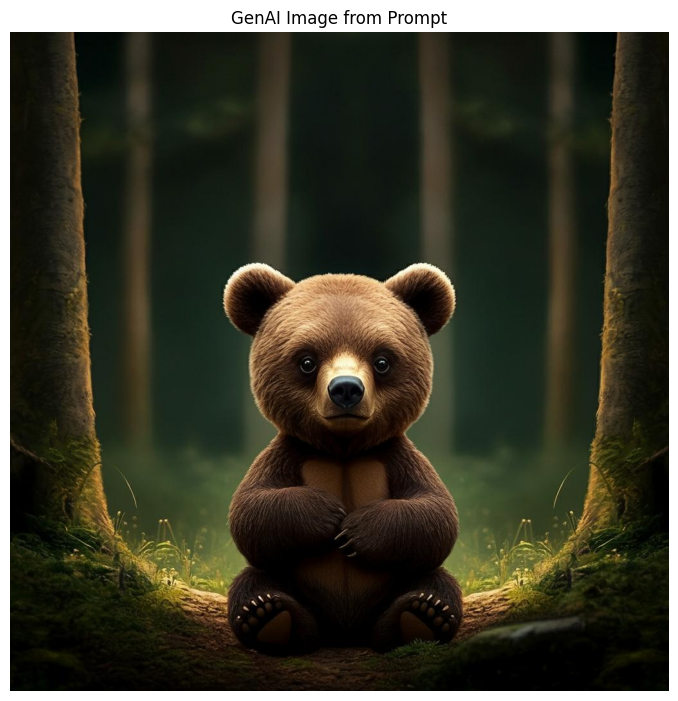

Image created with imagen-3.0-generate-001 and the following prompt: normal  realistic  normal  cute  natural 
lighting  landscape bear  on the computer.

In [ ]:
# Invoke the model passing your prompt and see the imae saved.
%matplotlib inline

#from PIL import Image
#from IPython.display import display
try:
  images = model.generate_images(
      prompt=picture_prompt,

      # Optional parameters
      number_of_images=1,
      language="en",

      # You can't use a seed value and watermark at the same time.
      add_watermark=False,
      #seed=100,
      aspect_ratio="1:1",
      safety_filter_level="block_some",
      person_generation="allow_all",
  )

  # Save the image locally
  try:
    output_file=target_folder+os.sep+f"stem-002-genai-images-output{IMG_EXT}"
    images[0].save(location=output_file, include_generation_parameters=False)
    rprint(f"Your save location is {output_file}.")
    print(f"For prompt: {BOLD_START}{picture_prompt}{BOLD_END}")
    print("")
    caption_text=f"Image created with {AI_MODEL_TYPE} and the following prompt: {picture_prompt}."
  except Exception as e:
    rprint("There was a problem saving your image.")
    rprint(f"Your save location was {output_file}.")
    process_exception(e)

  #add an alt tag
  try:
    add_alt_text(target_folder+os.sep+f"stem-002-genai-images-output{IMG_EXT}", caption_text);
  except Exception as e:
    process_exception(e)

  try:
    plt.figure(figsize=(FIGURE_HEIGHT, FIGURE_WIDTH))
    plt.title(f"GenAI Image from Prompt")
    plt.imshow(PIL_Image.open(output_file))
    plt.grid(False)
    plt.axis('off')
    plt.show()
    rprint(caption_text)
    plt.close()

  except Exception as e:
    print("There was a problem displaying your image.  Contact your instructor for assistance.")
    process_exception(e)

except Exception as e:
  print("There was a problem creating your image.  Contact your instructor for assistance.")
  process_exception(e)

# Do you understand the stochastic nature of AI?

Definition of stochastic: randomly determined; having a random probability distribution or pattern that may be analyzed statistically but may not be predicted precisely.

***The behavior and performance of many machine learning algorithms are referred to as stochastic.***

Stochastic refers to a variable process where the outcome involves some randomness and has some uncertainty. It is a mathematical term and is closely related to “randomness” and “probabilistic” and can be contrasted to the idea of “deterministic.”

The stochastic nature of machine learning algorithms is an important foundational concept in machine learning and is required to be understand in order to effectively interpret the behavior of many predictive models.

+ A variable or process is stochastic if there is uncertainty or randomness involved in the outcomes.

+ Stochastic is a synonym for random and probabilistic, although is different from non-deterministic.

+ Many machine learning algorithms are stochastic because they explicitly use randomness during optimization or learning.

#### *** If this same prompt runs multiple times, do you expect to see the same picture every time....??? ***

References:
+ https://www.geeksforgeeks.org/deterministic-vs-stochastic-environment-in-ai/
+ https://machinelearningmastery.com/stochastic-in-machine-learning/

# Advanced Class

1. Utilize a configuration management schema such as: dotenv, config_parser, or similar API's to support loading model parameters in a configured manner.  Utilize that configuration to feed your program.

2.  Utilize STEM-003 to create a prompt to support your image creation.

3.  Embeed a watermark in your image.

4.  Add a caption (alt text) to your image using [Gemini's capabilities](https://ai.google.dev/gemini-api/docs/vision?lang=python).

5. Utilize the image manipulation techniques identified as [inpainting](https://cloud.google.com/vertex-ai/generative-ai/docs/image/edit-inpainting) to modify the image you create.